In [50]:
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, eval_clusterings_for_class, plot_2d_with_boundaries
shap.initjs()
%matplotlib inline

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [5]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
filter_lines = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], Line2D), zip(handles, labels)))
filter_paths = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], PathCollection), zip(handles, labels)))

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4.55 s, sys: 79.4 ms, total: 4.63 s
Wall time: 4.9 s


In [7]:
%%time
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values,
                       feature_precisions=feature_precisions)
for class_name in comparer.class_names:
    print(class_name)
    node.focus_class = class_name
    node.calculate_counterfactuals()
with open(f'explanations/clustering.pickle', 'wb') as f:
    pickle.dump(node.state, f)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 6min 9s, sys: 3.74 s, total: 6min 12s
Wall time: 6min 44s


In [6]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)
with open(f'explanations/clustering.pickle', 'rb') as f:
    state = pickle.load(f)
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, focus_class=None,
                       feature_precisions=feature_precisions, state=state)

# Interpretation

In [7]:
node = node.root
node.focus_class = None
classes = ['1']

I start by interpreting the individual classifiers' feature importances, shown in figure \ref{}. What's special about classifier B is, that $x_1$ has no importance at all. 

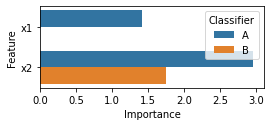

In [36]:
_, feature_importances_a = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
_, feature_importances_b = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
feature_order, _ = calc_feature_order(indiv_shap_values)
feature_idx = pd.Index(feature_names, name='Feature')
feature_importances_a = pd.Series(feature_importances_a.values, index=feature_idx, name='Importance')
feature_importances_b = pd.Series(feature_importances_b.values, index=feature_idx, name='Importance')
feature_importances = pd.concat({'A': feature_importances_a, 'B': feature_importances_b}, names=['Classifier'])
feature_importances = pd.DataFrame(feature_importances, columns=['Importance']).reset_index()
fig, ax = plt.subplots(figsize=(4, 1.5))
sns.barplot(orient='h', data=feature_importances, y='Feature', x='Importance', hue='Classifier', ax=ax)
plt.savefig('figures/bign-shap-indiv-featimp.pdf', bbox_inches='tight', pad_inches=0)

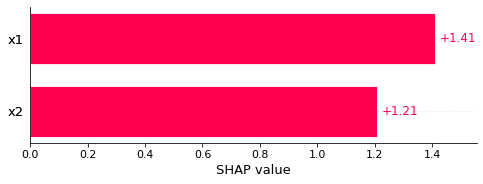

In [9]:
plot_feature_importance_bar(node.diff_feature_importances, feature_order=node.diff_feature_order)

In [10]:
from clustering import plot_indiv_dependence_curve_comparison_for_feature, _DEFAULT_FIGSIZE

This is confirmed in the individual dependence plots shown in figure \ref{fig:bign-indiv-depplots}: $x_1$ has no effect on B's outcomes. According to the difference dependence plots in the right column, up to a certain point B underestimates the effect of $x_1$ on class 1's outcome compared to A, and overestimates the effect above. Furthermore, it overestimates the effect of $x_2$ up to a certain point and underestimates its effect above. You can see that instances classified $(1,0)$ (orange) are located below the horizontal line at $s=0$ in $x_1$'s difference dependence plot, and that the instances classified $(0,1)$ are located above this line. Vice versa, this is the case for $x_2$'s difference dependence plots. So this has to be the direct reason for their different predictions, but the explanation is not yet sufficient.

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


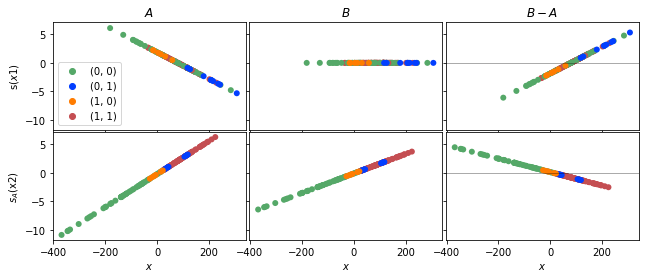

In [11]:
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*figsize[0], 2*figsize[1]), squeeze=False, constrained_layout=True, sharex='all', sharey='all')
node.plot_indiv_feature_dependence('x1', classes=classes, axs=axs[0:1].T)
node.plot_indiv_feature_dependence('x2', classes=classes, axs=axs[1:2].T)
axs = plt.gca().figure.axes
axs[0].set_ylabel('s($x1$)')
axs[0].set_title('$A$')
axs[1].set_title('$B$')
axs[2].set_title('$B-A$')
for ax in axs[3:]:
    ax.set_title(None)
    ax.set_xlabel('$x$')
axs[0].legend()
plt.savefig('figures/bign-indiv-depplots.pdf', bbox_inches='tight', pad_inches=0)

In [72]:
from clustering import plot_dependence_curve

In [77]:
make_lm = lambda clf, feature: linregress(node.data[feature], node.indiv_shap_values[:, feature, clf + '.1'].values)
lm1 = make_lm('A', 'x1')
lm2 = make_lm('B', 'x1')

In [81]:
f = lambda x: lm1.intercept + lm1.slope * x
g = lambda x: lm2.intercept + lm2.slope * x

In [82]:
x = [-100, 200]

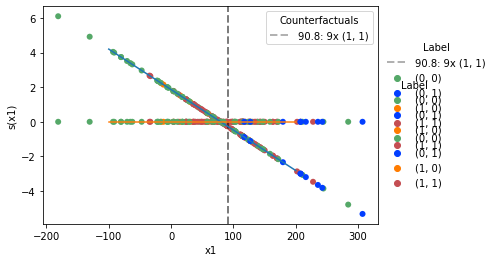

In [84]:
plot_dependence_curve(node, 'x1', 'A.1', kind='indiv')
plot_dependence_curve(node, 'x1', 'B.1', kind='indiv')
ax = plt.gca()
plt.plot(x, [f(x) for x in x])
plt.plot(x, [g(x) for x in x])

## Focus on instances classified $(0,1)$

In [92]:
node = node.root
node.focus_class = '(0, 1)'
classes = ['(0, 0)', '(0, 1)', '(1, 1)']

In [93]:
from clustering import plot_dependence_curves_for_nodes

In [94]:
node1 = node.descend().get_left().descend().get_parent(2)
node2 = node.descend().get_right()
node2, node3 = node2.descend().get_left(), node2.descend().get_right().descend().get_parent(3)
nodes = [node1, node2, node3]

In [43]:
node.descend().get_right().distance

107.31162216756495

In [44]:
node.descend().get_right().class_counts

(1, 1)    47
(0, 0)    23
(1, 0)     6
(0, 1)     5
dtype: int64

In [42]:
[n.distance for n in nodes]

[25.394590498193747, 29.49288167934965, 26.887303704195602]

In [46]:
[str(n) for n in nodes]

['LLR', 'LRL', 'LRRRR']

$x_1$'s lower counterfactual varies for all interpreted nodes.

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


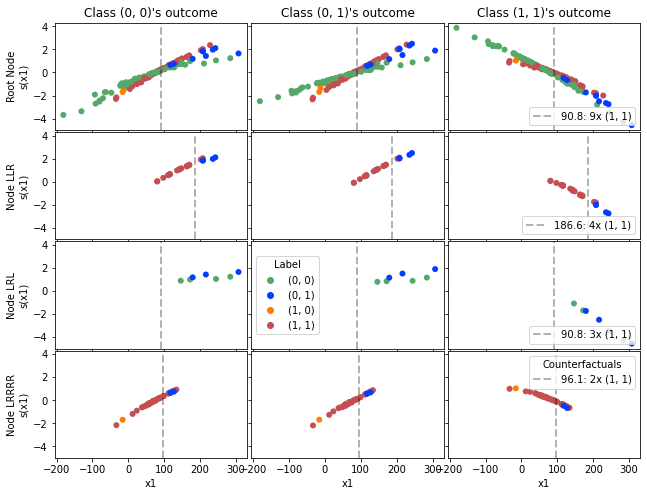

In [15]:
plot_dependence_curves_for_nodes(node, *nodes,
                                 feature='x1', labels=classes, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[7]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='center left', title='Label')
plt.savefig('figures/bign-depplots-01-x1.pdf', bbox_inches='tight', pad_inches=0)

$x_2$'s lower counterfactuals are equal for all nodes, only the upper counterfactual explanation varies.

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


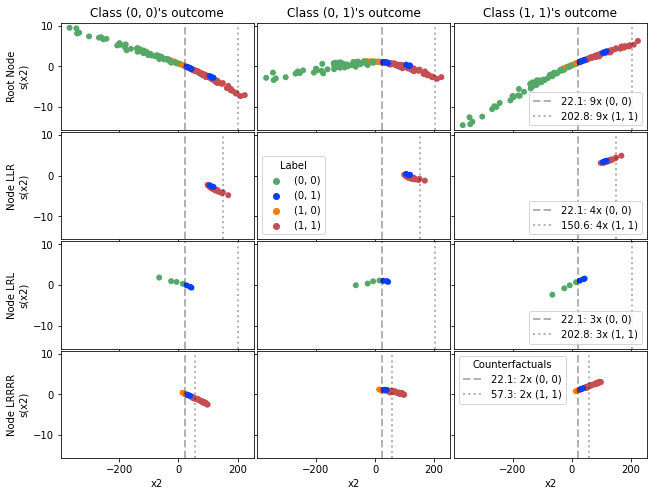

In [16]:
plot_dependence_curves_for_nodes(node, *nodes,
                                 feature='x2', labels=classes, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[4]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='lower left', title='Label')
plt.savefig('figures/bign-depplots-01-x2.pdf', bbox_inches='tight', pad_inches=0)

I conclude, that B tends to estimate label 1 more often than A when $x_2 \gt 22.1 \land x_1 > 90.8$. But the upper boundary of $x_2$ and the lower boundary of $x_1$ depend on both features' values. Examples for such are shown below in the rules derived for the local cluster nodes.

In [18]:
for n in [node] + nodes:
    rule = n.rule_from_counterfactuals(order=np.arange(len(feature_names)), latex=True)[0]
    print(f'\item \emph{{Node {n}}}: ${rule}$')

\item \emph{Node root}: $x_1 > 90.8 \land 22.1 < x_2 \leq 202.7$
\item \emph{Node LLR}: $x_1 > 186.6 \land 22.1 < x_2 \leq 150.5$
\item \emph{Node LRL}: $x_1 > 90.8 \land 22.1 < x_2 \leq 202.7$
\item \emph{Node LRRRR}: $x_1 > 96.1 \land 22.1 < x_2 \leq 57.2$


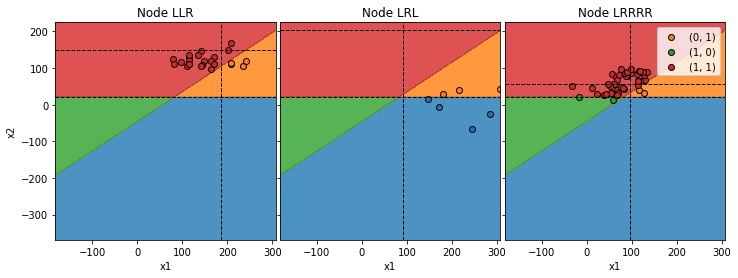

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharex='all', sharey='all')
for idx, (n, ax) in enumerate(zip(nodes, axs)):
    is_first = idx == 0
    plot_2d_with_boundaries(n, fig=fig, ax=ax)
    if not is_first:
        ax.set_ylabel(None)
    ax.set_title(f'Node {n}')
axs[0].get_legend().remove()
axs[1].get_legend().remove()
plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('figures/bign-01-instances.pdf', bbox_inches='tight', pad_inches=0)

## Focus on instances classified $(1,0)$

In [47]:
node = node.root
node.focus_class = '(1, 0)'
classes = ['(0, 0)', '(1, 0)', '(1, 1)']

In [48]:
node1 = node.descend().get_left().descend().get_parent(2)
node2 = node.descend().get_right()
nodes = [node1, node2]

In [49]:
[str(n) for n in nodes]

['LRRL', 'LRRR']

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


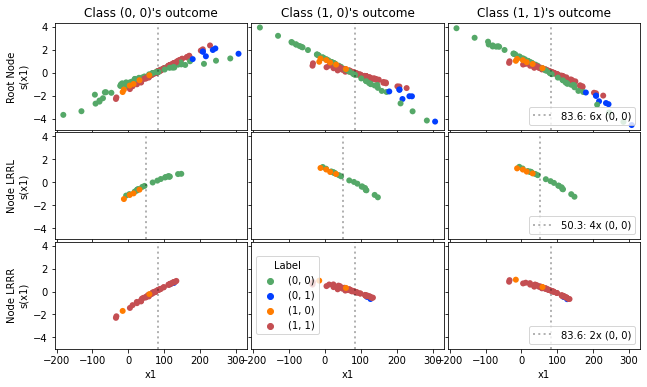

In [23]:
plot_dependence_curves_for_nodes(node, *nodes,
                                 feature='x1', labels=classes, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[7]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='center left', title='Label')
plt.savefig('figures/bign-depplots-10-x1.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


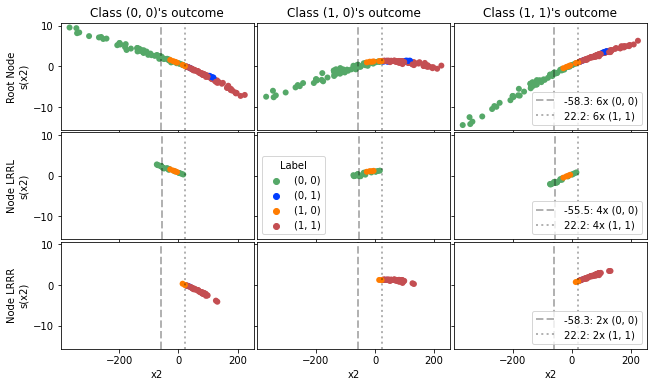

In [24]:
plot_dependence_curves_for_nodes(node, *nodes,
                                 feature='x2', labels=classes, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[4]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='lower left', title='Label')
plt.savefig('figures/bign-depplots-10-x2.pdf', bbox_inches='tight', pad_inches=0)

In [26]:
for n in [node] + nodes:
    rule = n.rule_from_counterfactuals(order=np.arange(len(feature_names)), latex=True)[0]
    print(f'\item \emph{{Node {n}}}: ${rule}$')

\item \emph{Node root}: $x_1 \leq 83.5 \land -58.3 < x_2 \leq 22.1$
\item \emph{Node LRRL}: $x_1 \leq 50.2 \land -55.5 < x_2 \leq 22.1$
\item \emph{Node LRRR}: $x_1 \leq 83.5 \land -58.3 < x_2 \leq 22.1$


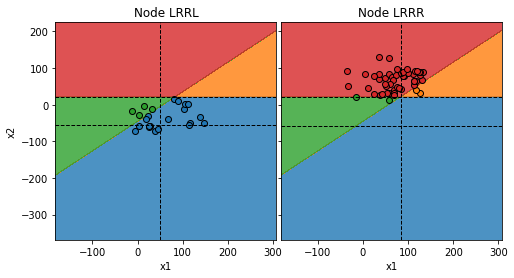

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharex='all', sharey='all')
for idx, (n, ax) in enumerate(zip(nodes, axs)):
    is_first = idx == 0
    plot_2d_with_boundaries(n, fig=fig, ax=ax)
    if not is_first:
        ax.set_ylabel(None)
    ax.set_title(f'Node {n}')
axs[0].get_legend().remove()
axs[1].get_legend().remove()
plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('figures/bign-10-instances.pdf', bbox_inches='tight', pad_inches=0)

# Evaluation

In [27]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

In [28]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [33]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/test.log_odds.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Exact explainer: 10001it [00:33, 236.07it/s]                          


CPU times: user 31.1 s, sys: 538 ms, total: 31.6 s
Wall time: 33.8 s


In [29]:
with open('explanations/test.log_odds.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [31]:
metrics = eval_clusterings(node, X_test, shap_values_test)
metrics

,Precision,Recall,F1 Score,Support,Label,Nodes,Constraints,Distance
0,0.780185,1.000000,0.876521,4213.0,"(0, 0)",1,1,832.705964
1,0.842980,0.999051,0.914404,4213.0,"(0, 0)",2,3,269.285518
2,0.842980,0.999051,0.914404,4213.0,"(0, 0)",3,4,117.062504
3,0.842980,0.999051,0.914404,4213.0,"(0, 0)",4,6,94.575025
4,0.842980,0.999051,0.914404,4213.0,"(0, 0)",5,8,84.507920
...,...,...,...,...,...,...,...,...
96,0.977210,0.994690,0.985873,3578.0,"(1, 1)",47,92,0.009115
97,0.977210,0.994690,0.985873,3578.0,"(1, 1)",48,94,0.006094
98,0.977210,0.994690,0.985873,3578.0,"(1, 1)",49,96,0.004968
99,0.977210,0.994690,0.985873,3578.0,"(1, 1)",50,98,0.000337


In [32]:
grouped_metrics, constraints = group_metrics(metrics, by='Distance', direction='down')
with open('data/fidelity-shap.pickle', 'wb') as f:
    pickle.dump((grouped_metrics, constraints), f)

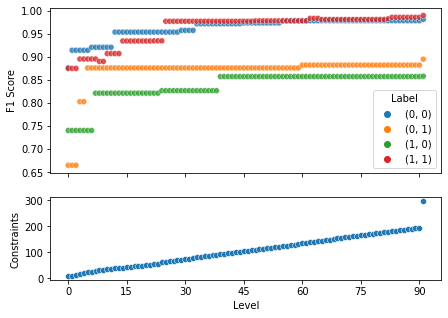

In [33]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [34]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Nodes  Constraints  \
Level                                                                         
0     0  (0, 0)   0.780185  1.000000  0.876521   4213.0    1.0          1.0   
      1  (0, 1)   0.498775  0.997062  0.664925   1021.0    1.0          3.0   
      2  (1, 0)   0.663333  0.837542  0.740327   1188.0    1.0          3.0   
      3  (1, 1)   0.777826  1.000000  0.875031   3578.0    1.0          1.0   
1     0  (0, 0)   0.842980  0.999051  0.914404   4213.0    2.0          3.0   
...         ...        ...       ...       ...      ...    ...          ...   
90    3  (1, 1)   0.977210  0.994690  0.985873   3578.0   50.0         98.0   
91    0  (0, 0)   0.995604  0.967719  0.981464   4213.0   57.0         98.0   
      1  (0, 1)   0.987013  0.818805  0.895075   1021.0    9.0         27.0   
      2  (1, 0)   0.959417  0.776094  0.858074   1188.0    6.0         18.0   
      3  (1, 1)   0.987212  0.992454  0.989826   3578.0   78.0        154.0   

           Distance  
Level                
0     0  832.705964  
      1  832.705964  
      2  832.705964  
      3  832.705964  
1     0  269.285518  
...             ...  
90    3    0.000337  
91    0    0.000000  
      1    0.000000  
      2    0.000000  
      3    0.000000  

[368 rows x 8 columns]

In [35]:
constraints

Level
0       8.0
1      10.0
2      11.0
3      16.0
4      18.0
      ...  
87    189.0
88    190.0
89    192.0
90    194.0
91    297.0
Name: Constraints, Length: 92, dtype: float64

In [52]:
node = node.root
node.focus_class = '(0, 1)'
nodes = [node.get(name) for name in ['LLR', 'LRL', 'LRRRR']]

In [53]:
eval_clusterings_for_class(node.focus_class, nodes, X_test, shap_values_test)

Precision      0.887437
Recall         0.864838
F1 Score       0.875992
Support          1021.0
Label            (0, 1)
Nodes                 3
Constraints           9
Name: True, dtype: object

In [54]:
node = node.root
node.focus_class = '(1, 0)'
nodes = [node.get(name) for name in ['LRRL', 'LRRR']]

In [55]:
eval_clusterings_for_class(node.focus_class, nodes, X_test, shap_values_test)

Precision      0.826235
Recall         0.816498
F1 Score       0.821338
Support          1188.0
Label            (1, 0)
Nodes                 2
Constraints           6
Name: True, dtype: object